# Decision Tree

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from imblearn.over_sampling import SMOTE
from sklearn import tree
from graphviz import Source
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder

### What are the "main" criteria to get a Good credit rating

In [109]:
df = pd.read_csv("Data_CreditDefault.csv")
df2 = df.copy()
df.head()

,Duration,Amount,History,EmpStatus,Gender,Age,Rating
0,6,1169,Critical,moreSeven,Male,67,Good
1,48,5951,PaidDuly,lessFour,Female,22,Bad
2,12,2096,Critical,lessSeven,Male,49,Good
3,42,7882,PaidDuly,lessSeven,Male,45,Good
4,24,4870,PayDelay,lessFour,Male,53,Bad


Let us take a look at our dataset first

In [6]:
print(df.dtypes)
df.info()
df.describe()


Duration      int64
Amount        int64
History      object
EmpStatus    object
Gender       object
Age           int64
Rating       object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Duration   1000 non-null   int64 
 1   Amount     1000 non-null   int64 
 2   History    1000 non-null   object
 3   EmpStatus  1000 non-null   object
 4   Gender     1000 non-null   object
 5   Age        1000 non-null   int64 
 6   Rating     1000 non-null   object
dtypes: int64(3), object(4)
memory usage: 54.8+ KB


,Duration,Amount,Age
count,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,35.546000
std,12.058814,2822.736876,11.375469
min,4.000000,250.000000,19.000000
25%,12.000000,1365.500000,27.000000
50%,18.000000,2319.500000,33.000000
75%,24.000000,3972.250000,42.000000
max,72.000000,18424.000000,75.000000


Text(0.5, 1.0, 'Rating')

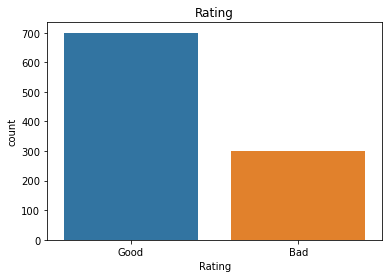

In [20]:
sb.countplot(data=df, x='Rating').set_title("Rating")

Text(0.5, 1.0, 'History')

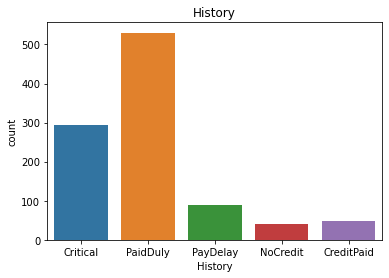

In [19]:
sb.countplot(data=df, x='History').set_title("History")

Text(0.5, 1.0, 'Employment Status')

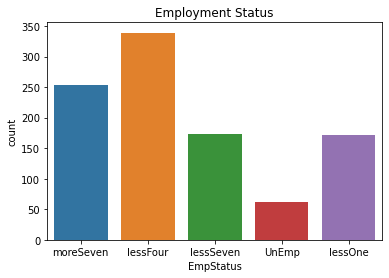

In [21]:
sb.countplot(data=df, x='EmpStatus').set_title("Employment Status")

<AxesSubplot:xlabel='Amount', ylabel='Rating'>

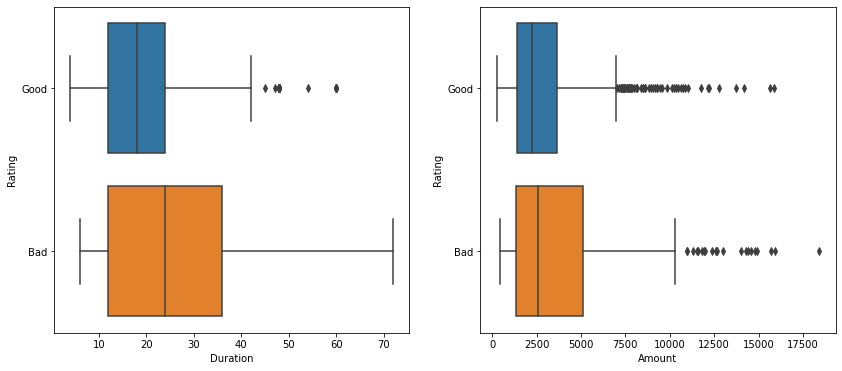

In [26]:
f, axes = plt.subplots(1,2, figsize=(14,6))
sb.boxplot(data=df, y = 'Rating', x='Duration',ax=axes[0])
sb.boxplot(data=df, y = 'Rating', x='Amount',ax=axes[1])

Initial Gini = 1 - a(x/n)^2 - b(y/n)^2, where a and b are bias/penalty. 

Duration: Customers who applied for credit/loan (in Months)

Amount: Amount of the new loans they applied for
Gender: Gender

Empstatus: Employment in years 
Age: Age

History: Did you previously hold any loans?
* No Credit: means has never taken a loan.
* Credit Paid: Paid finish
* Paid Delay: Pay with delay
* Critical: You defaulted/could not pay
* Paid Duly: Paid your installments duly

Rating: 
* Good: Get the Loan
* Bad: Will not get the loan

### Questions to ask ourselves? (IMPT)
1) Is the response balanced? How to fix it?

2) How to "encode" categorical predictors

3) Is a single DecisionTree "robust" enough

4) Which hyperparameters are the best?

5) Which "measure" of accuracy should we adopt?

Manually Encoding the History Category and Employment Status

In [111]:
df2 = df.copy()
hist = []
for i in range(df.shape[0]):
    if(df['History'][i] == 'NoCredit'):
        hist.append(0)
    elif(df['History'][i] == 'CreditPaid'):
        hist.append(1)
    elif(df['History'][i] == 'PayDelay'):
        hist.append(3)
    elif(df['History'][i] == 'Critical'):
        hist.append(4)
    else:
        hist.append(2)
df2['History'] = hist

emp = []
for i in range(df.shape[0]):
    if(df['EmpStatus'][i] == 'UnEmp'):
        emp.append(0)
    elif(df['EmpStatus'][i] == 'lessOne'):
        emp.append(1)
    elif(df['EmpStatus'][i] == 'lessFour'):
        emp.append(4)
    elif(df['EmpStatus'][i] == 'lessSeven'):
        emp.append(7)
    else:
        emp.append(10)
df2['EmpStatus'] = emp

enc = OrdinalEncoder()
df2['Gender'] = enc.fit_transform(df[['Gender']])

df2.head()

,Duration,Amount,History,EmpStatus,Gender,Age,Rating
0,6,1169,4,10,1.0,67,Good
1,48,5951,2,4,0.0,22,Bad
2,12,2096,4,7,1.0,49,Good
3,42,7882,2,7,1.0,45,Good
4,24,4870,3,4,1.0,53,Bad


### Having encoded, let us try to use DecisionTree to predict

<AxesSubplot:>

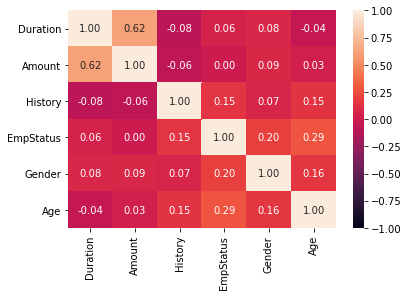

In [112]:
sb.heatmap(df2.corr(), fmt="0.2f", annot=True, vmax=1,vmin=-1)

In [225]:
y = df2[['Rating']]
X = df2[['Duration','Amount','History','EmpStatus','Age']]

Let us try using SMOTE now

In [226]:
sm = SMOTE()
X_sm , y_sm = sm.fit_resample(X, y)
print("Before Resampling:", len(X))
print("After Resampling:", len(X_sm))

Before Resampling: 1000
After Resampling: 1400


In [227]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.25)
print("Train set:",len(X_train))
print("Test set:",len(X_test))

Train set: 1050
Test set: 350


# Decision Tree Classifier

In [228]:
from sklearn.tree import DecisionTreeClassifier
dectree = DecisionTreeClassifier(max_depth=10)

In [229]:
dectree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [257]:
tree_file = tree.export_graphviz(
            dectree,
            out_file =  "myTreeName.dot",
            feature_names = list(X.columns),
            filled = True,
            rounded = True)

s = Source.from_file("myTreename.dot")
s.view()

'myTreename.dot.pdf'

<AxesSubplot:>

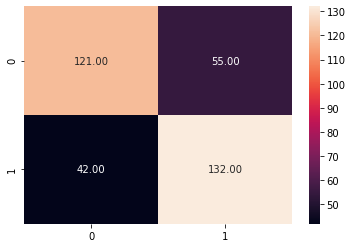

In [231]:
y_pred = dectree.predict(X_test)
sb.heatmap(confusion_matrix(y_test, y_pred), fmt='0.2f', annot=True)

In [232]:
# Can we get the accruacy score
from sklearn.model_selection import cross_val_score
cross_val_score(dectree, X_train, y_train, cv=5)

array([0.72380952, 0.68571429, 0.65714286, 0.6952381 , 0.65714286])

In [233]:
dectree.feature_importances_

array([0.18540761, 0.31344228, 0.24503653, 0.10402513, 0.15208846])

We can see the feature importance here let us try to do a barplot for this

<AxesSubplot:>

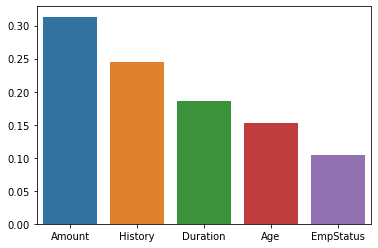

In [234]:
featureimp = sorted(list(zip( X_train.columns,dectree.feature_importances_)),key = lambda x: x[1],reverse=True)
featureimp
y = []
x = []
for i in featureimp:
    y.append(i[1])
    x.append(i[0])
sb.barplot(x=x, y = y)

# Random Forest Classifier

In [248]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators=500, max_depth=5)

<ipython-input-251-26d12f74a0a9>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomforest.fit(X_train, y_train)


<AxesSubplot:>

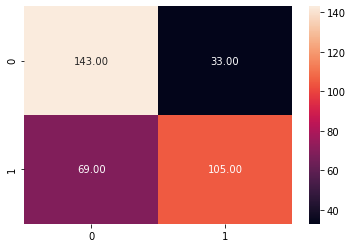

In [251]:
randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_test)
sb.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='0.2f')

<AxesSubplot:>

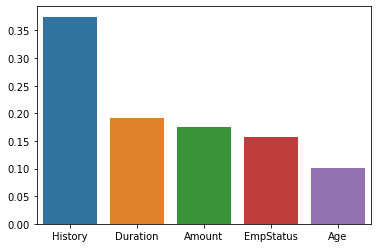

In [245]:
featureimp = sorted(list(zip( X_train.columns,randomforest.feature_importances_)),key = lambda x: x[1],reverse=True)
featureimp
y = []
x = []
for i in featureimp:
    y.append(i[1])
    x.append(i[0])
sb.barplot(x=x, y = y)

In [246]:
cross_val_score(randomforest, X_train, y_train, cv=5)

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

array([0.6952381 , 0.76190476, 0.73333333, 0.71904762, 0.7047619 ])

# Hyper Parameter Tuning using GridSearch (GridSearchCV)
GridSearchCV is a cross validation that takes a model family 

In [274]:
from sklearn.model_selection import GridSearchCV
param = {'n_estimators':[i for i in range(100,500,50)], 'max_depth':[i for i in range(1,10)]}

#estimator use the whole class not the object
grid_search = GridSearchCV(estimator = RandomForestClassifier(), cv=5, param_grid = param, scoring='roc_auc')

Trying different scoring, roc_auc, f1 etc

In [275]:
grid_search.fit(X_train, y_train)

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yihao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                          450]},
             scoring='roc_auc')

In [276]:
grid_search.best_params_

{'max_depth': 9, 'n_estimators': 450}